<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Общая-информация-о-датафрейме" data-toc-modified-id="Общая-информация-о-датафрейме-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Общая информация о датафрейме</a></span></li><li><span><a href="#Деление-данных-на-выборки" data-toc-modified-id="Деление-данных-на-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Деление данных на выборки</a></span></li><li><span><a href="#Исследование-различных-моделей" data-toc-modified-id="Исследование-различных-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование различных моделей</a></span></li><li><span><a href="#Проверка-моделей-на-тестовой-выборке" data-toc-modified-id="Проверка-моделей-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка моделей на тестовой выборке</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li></ul></div>


# Рекомендация тарифов

Оператор мобильной связи **«Мегалайн»** выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: **«Смарт»** или **«Ультра»**.

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

Необходимо построить модель с максимально большим значением _accuracy_ (минимум 0,75).

## Общая информация о датафрейме

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

try:
    tariffs = pd.read_csv('/datasets/users_behavior.csv')
    
except:
    tariffs = pd.read_csv('home/an4ouce/datasets/users_behavior.csv')
    
tariffs.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [2]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


На первый взгляд все хорошо. На всякий случай проверим дубликаты:

In [3]:
tariffs.duplicated().sum()

0

Дубликатов нет. Проверим, адекватны ли значения в столбце с тарифом (только 0 и 1):

In [4]:
tariffs['is_ultra'].value_counts().to_frame()

,is_ultra
0,2229
1,985


И вновь все хорошо. 

Проверим данные на мультиколлинеарность:

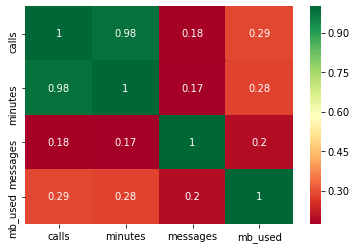

In [5]:
sns.heatmap(tariffs[['calls', 'minutes', 'messages', 'mb_used']].corr(), cmap='RdYlGn', annot=True)
plt.show()

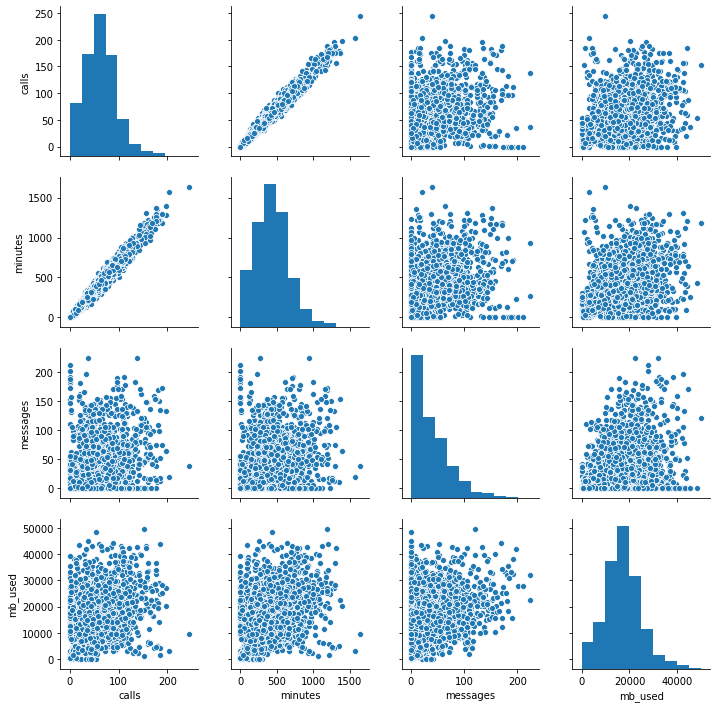

In [6]:
sns.pairplot(tariffs[['calls', 'minutes', 'messages', 'mb_used']])
plt.show()

Видим мультиколлинеарность двух признаков - 'calls' и 'minutes'. Для того, чтобы создать модель, рекомендующую пользователю тарифный план, нам нужны только количество минут звонков, количество смс и количество израсходованного интернет-трафика. Само число звонков непоказательно - могут быть как короткие звонки (до минуты), так и длиной в несколько часов.
Удалим признак 'calls' из датафрейма:

In [7]:
tariffs = tariffs.drop('calls', axis=1)
tariffs.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


Снова взглянем на матрицу корреляции уже без признака 'calls':

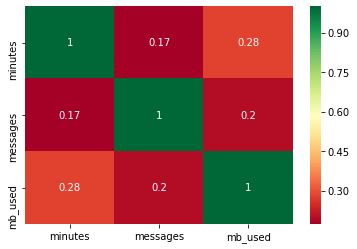

In [8]:
sns.heatmap(tariffs[['minutes', 'messages', 'mb_used']].corr(), cmap='RdYlGn', annot=True)
plt.show()

Отлично, от мультиколлинеарности избавились, пора заняться делением данных на выборки.

## Деление данных на выборки

Напишем функцию, которая будет делить наш датафрейм на обучающую, валидационную и тестовую выборки. Распределение долей будет такое: обучающая выборка - 60% данных, валидационная и тестовая - по 20% данных. Такое соотношение оптимально, нет риска переобучения модели.

In [9]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=123):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [10]:
tariffs_train, tariffs_validate, tariffs_test = train_validate_test_split(tariffs)

In [11]:
tariffs_train.shape[0]

1928

In [12]:
tariffs_validate.shape[0]

642

In [13]:
tariffs_test.shape[0]

644

Получили три выборки:
* обучающая - 1928 объектов;
* валидационная - 642 объекта;
* тестовая - 644 объекта.

Теперь сформируем переменные, содержащие признаки для модели и целевой признак.

In [14]:
#признаки модели на обучающей выборке
features_train = tariffs_train.drop('is_ultra', axis=1)
#целевой признак
target_train = tariffs_train['is_ultra']

#признаки модели на валидационной выборке
features_valid = tariffs_validate.drop('is_ultra', axis=1)
#целевой признак
target_valid = tariffs_validate['is_ultra']

#признаки модели на тестовой выборке
features_test = tariffs_test.drop('is_ultra', axis=1)
#целевой признак
target_test = tariffs_test['is_ultra']

## Исследование различных моделей

Так как целевой признак категориальный, то перед нами стоит задача бинарной классификации (0 или 1). Будем рассматривать три модели для решения указанной задачи:
* **решающее дерево**
* **случайный лес**
* **логистическая регрессия**

Начнем с решающего дерева.

### Решающее дерево.

В целях получения наибольшего значения accuracy на валидационной выборке, будем вручную менять гиперпараметры модели:

* _max_depth_ - максимальная глубина дерева (будем рассматривать от 1 до 5, так как при глубине более 5 модель обычно переобучена)
* _criterion_ - критерий (Джини или энтропийный)
* _min_samples_split_ - минимальное количество объектов, необходимое для разделения внутреннего узла (от 2 до 5)
* _min_samples_leaf_ - минимальное количество объектов в листе (от 1 до 5)

In [15]:
best_model_tree = None
best_result_tree = 0
for depth in range(1, 6):
    for criterion in ['gini', 'entropy']:
        for split in range(2, 6):
            for leaf in range(1, 6):
                model_tree = DecisionTreeClassifier(random_state=1234, max_depth=depth, criterion=criterion, \
                                                    min_samples_split=split, min_samples_leaf=leaf)
                model_tree.fit(features_train, target_train)
                predictions_tree = model_tree.predict(features_valid) 
                result_tree = accuracy_score(target_valid, predictions_tree).round(3)
                if result_tree > best_result_tree:
                    best_model_tree = model_tree
                    best_result_tree = result_tree
                 
print('Accuracy лучшей модели на валидационной выборке:', best_result_tree) 
print('Параметры лучшей модели:', best_model_tree)

Accuracy лучшей модели на валидационной выборке: 0.769
Параметры лучшей модели: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')


Получили значение accuracy равное 0,769 на валидационной выборке при следующих гиперпараметрах решающего дерева:
* _max_depth_ = 5
* _criterion_ = entropy
* _min_samples_split_ = 2
* _min_samples_leaf_ = 1 

### Случайный лес.
Теперь рассмотрим следующую модель - случайный лес. Будем менять количество деревьев (n_estimators) от 1 до 5. При большем количестве деревьев улучшится точность предсказаний модели, но упадет скорость работы.

In [16]:
best_model_forest = None
best_result_forest = 0
for est in range(1, 6):
    model_forest = RandomForestClassifier(random_state=1234, n_estimators=est) 
    model_forest.fit(features_train, target_train)
    predictions_forest = model_forest.predict(features_valid) 
    result_forest = accuracy_score(target_valid, predictions_forest).round(3)
    if result_forest > best_result_forest:
        best_model_forest = model_forest 
        best_result_forest = result_forest
        
print('Accuracy лучшей модели на валидационной выборке:', best_result_forest) 
print('Параметры лучшей модели:', best_model_forest)

Accuracy лучшей модели на валидационной выборке: 0.752
Параметры лучшей модели: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)


Получили значение accuracy равное 0,752 на валидационной выборке при количестве деревьев равном 4.

### Логистическая регрессия.
Теперь рассмотрим логистическую регрессию:

In [17]:
model_regress = LogisticRegression(random_state=1234, class_weight=None, solver='lbfgs') 
model_regress.fit(features_train, target_train) 
predictions_regress = model_regress.predict(features_valid)
result_regress = accuracy_score(target_valid, predictions_regress).round(3)

print("Accuracy модели логистической регрессии на валидационной выборке:", result_regress)
print('Параметры лучшей модели:', model_regress)

Accuracy модели логистической регрессии на валидационной выборке: 0.707
Параметры лучшей модели: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Для логистической регрессии мы получили самое низкое значение accuracy на валидационной выборке, равное 0,707.

Теперь проверим все три модели (с подобранными гиперпараметрами) на тестовой выборке.

## Проверка моделей на тестовой выборке

### Решающее дерево.

In [18]:
predictions_test_tree = best_model_tree.predict(features_test) 
result_test_tree = accuracy_score(target_test, predictions_test_tree).round(3)
print('Accuracy модели на тестовой выборке', result_test_tree)

Accuracy модели на тестовой выборке 0.795


### Случайный лес.

In [19]:
predictions_test_forest = best_model_forest.predict(features_test) 
result_test_forest = accuracy_score(target_test, predictions_test_forest).round(3) 
print('Accuracy модели на тестовой выборке', result_test_forest)

Accuracy модели на тестовой выборке 0.783


### Логистическая регрессия.

In [20]:
predictions_test_regress = model_regress.predict(features_test)
result_test_regress = accuracy_score(target_test, predictions_test_regress).round(3)
print('Accuracy модели на тестовой выборке', result_test_regress)

Accuracy модели на тестовой выборке 0.75


### Вывод.

Для наглядности построим столбчатую диаграмму, где отобразим значения accuracy на валидационной и тестовой выборке для наших моделей.

In [21]:
data = {'validate':[best_result_tree, best_result_forest, result_regress], 'test':[result_test_tree, 
                                                                                   result_test_forest,
                                                                                   result_test_regress]}
table = pd.DataFrame(data)
table.index = ['Решающее дерево', 'Случайный лес', 'Логистическая регрессия']
table

,validate,test
Решающее дерево,0.769,0.795
Случайный лес,0.752,0.783
Логистическая регрессия,0.707,0.750


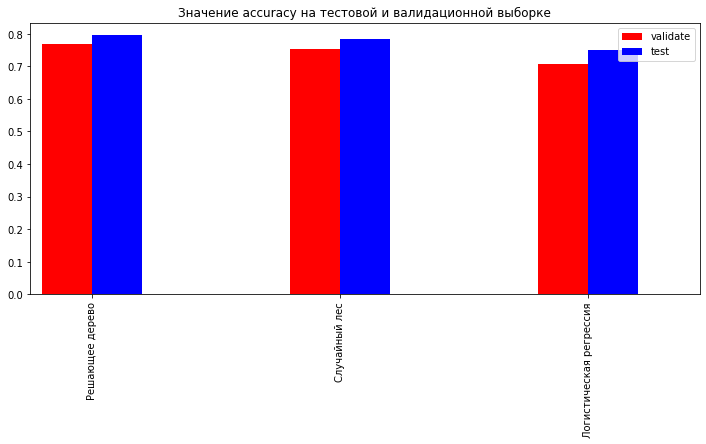

In [22]:
ax=plt.gca()
                                            
table.plot(y='validate', kind='bar', ax=ax, position=1, color='red', figsize=(12,5), width=0.2)
table.plot(y='test', kind='bar', ax=ax, position=0, color='blue', figsize=(12,5), width=0.2)

plt.title('Значение accuracy на тестовой и валидационной выборке')

plt.show()

Лучший результат показывает решающее дерево (accuracy на тестовой выборке 0,795), случайный лес немного уступает (0,783). Логистическая регрессия показала наихудший результат (0,75).

In [23]:
table['delta'] = table['test']-table['validate']
display(table['delta'].to_frame())

,delta
Решающее дерево,0.026
Случайный лес,0.031
Логистическая регрессия,0.043


Все модели работают лучше на тестовой выборке, что говорит о достаточном обучении моделей. Но если мы взглянем на разницу между тестовым и валидационным значением accuracy, то самая маленькая разница у решающего дерева, а значит, модель ведет себя предсказуемо. Возможно, нужна более тонкая настройка гиперпараметров моделей для получения лучшего результата.

## Проверка модели на адекватность

Для проверки модели на адекватность нужно сравнить модель со случайной. Создадим столбец, случайным образом заполняемый нулями и единицами:

In [24]:
tariffs_test['is_ultra_rand'] = np.random.randint(2, size=tariffs_test.shape[0])
tariffs_test['is_ultra_rand'].value_counts()

0    333
1    311
Name: is_ultra_rand, dtype: int64

In [25]:
tariffs_test.head()

,minutes,messages,mb_used,is_ultra,is_ultra_rand
2967,583.37,58.0,20898.57,1,0
869,482.18,40.0,11178.07,1,1
3159,200.09,102.0,27432.25,1,1
1978,350.29,6.0,22870.78,0,0
873,556.84,71.0,19869.21,0,0


Создадим переменные с целевым признаком (target_check) и "предсказаниями" случайной модели (predict_rand):

In [26]:
target_check = tariffs_test['is_ultra']
predict_rand = tariffs_test['is_ultra_rand']

In [27]:
result_test_check = accuracy_score(target_check, predict_rand).round(3)
print('Accuracy случайной модели:', result_test_check)

Accuracy случайной модели: 0.474


**Вывод:** accuracy случайной модели получилась примерно 0,5 (верояность 50/50, что называется, "пальцем в небо").
Accuracy всех наших моделей выше точности случайной модели, что говорит об адекватности моделей.